In [339]:
# Exercise sheet 4.2
# Jian Zhang, 219012058
# 19.10.31

In [117]:
import numpy as np
import sympy as sp
from sympy.parsing import sympy_parser as spp
import time
import matplotlib.pyplot as plt

In [149]:
# Globalized Newton's Method
# parameters:
# - obj, objective function
# - x0, the initial point
# - tol, tolerance, method should stop if the criterion 'gradient f(x_k) <= tol'
# - B1, B2, p, parameters for Newton condition
# - s, sigma, gamma, parameters for backtracking and Armijo condition
# - grad_method, default False, if True, use gradient as step
def newton_glob(obj, x0, tol, B1, B2, p, s, sigma, gamma, grad_method=False):
    
    start_time = time.time()
    print('Initial point', x0, 'Start iterating:')
    
    xn = [] # used to store iterates xk
    gn_norm = [] # used to store iterates of gradient xk
    iterations = 0
    
    x1, x2 = sp.symbols('x1 x2')
    symbols = obj.free_symbols
    # calculate gradient
    grad = sp.Matrix([sp.diff(obj, i) for i in symbols])
    # calculate Hessian
    hess = sp.Matrix([[sp.diff(g, i) for i in symbols] for g in grad])
    # inverse of Hessian
    if hess.det():
        hess_inv = hess.inv()
    else:
        print('det of objective function Hessian is not invertible')
    
    cur_point = x0
    
    cur_grad = grad.evalf(subs = {x1:x0[0],x2:x0[1]})
    norm = float(cur_grad.norm())
            
    cur_hess = hess.evalf(subs = {x1:x0[0],x2:x0[1]})
    
    while norm > tol:
        
        xn.append(cur_point)
        gn_norm.append(norm)
        
        # stop if Hessian is singular
        if cur_hess.det() == 0:
            print('Hessian is singular')
            break
        
        # Gradient method
        step = -cur_grad.T
        # Newton method
        if not grad_method:
            d = -cur_grad.T * cur_hess.inv()
            # calculate norm
            norm_d = float(d.norm())
            norm_d_p = norm_d ** p
            norm_d_sq = norm_d ** 2

            Min = min(B1,B2*norm_d_p)*norm_d_sq
            if np.dot(-cur_grad.T, d.T) >= Min:
                step = d
            else:
                step = -cur_grad.T
                    
        alpha = s
        pre_point = cur_point
        pre_value = obj.evalf(subs = {x1:pre_point[0], x2:pre_point[1]})
        cur_point = [pre_point[0] + alpha * step[0], pre_point[1] + alpha * step[1]]
        cur_value = obj.evalf(subs = {x1:cur_point[0], x2:cur_point[1]})
        
        while cur_value > pre_value + gamma*alpha*np.dot(cur_grad.T, step.T):
            alpha = alpha * sigma
            cur_point = [pre_point[0] + alpha * step[0], pre_point[1] + alpha * step[1]]
            cur_value = obj.evalf(subs = {x1:cur_point[0], x2:cur_point[1]})
        
        iterations += 1
        
        cur_grad = grad.evalf(subs = {x1:cur_point[0],x2:cur_point[1]})
        norm = float(cur_grad.norm())
        
        cur_hess = hess.evalf(subs = {x1:cur_point[0],x2:cur_point[1]})
        
        #print(iterations, cur_point)
        #if iterations % 500 == 0:
        #    print('iterations:', iterations, cur_point, 'Time Cost(s):', '%.3f'%(time.time() - start_time))
        
    print('Total', iterations, 'iterations. Time Cost(s):', '%.3f'%(time.time() - start_time), \
          'Converged point:', cur_point, '\n')
    
    return xn, gn_norm, cur_point
        

In [82]:
# Test objective function
f1 = spp.parse_expr('-13 + x1 + ((5 - x2) * x2 - 2) * x2')
f2 = spp.parse_expr('-29 + x1 + ((x2 + 1) * x2 - 14) * x2')
f = f1**2 + f2**2

In [83]:
# Verify that x1* is a globbal minimizer of f
def verifyGlobalMin(f):
    x1, x2 = sp.symbols('x1 x2')
    print('f(x1*) = ', f.evalf(subs = {x1:5,x2:4}))
    print('f(x2*) = ', f.evalf(subs = {x1:(53 + 4 * np.sqrt(22)) / 3, x2:(2 + np.sqrt(22)) / 3}))
    print('f(x3*) = ', f.evalf(subs = {x1:(53 - 4 * np.sqrt(22)) / 3, x2:(2 - np.sqrt(22)) / 3}))

verifyGlobalMin(f)

f(x1*) =  1.07486017721073e-136
f(x2*) =  819.010259352310
f(x3*) =  48.9842536792400


Initial point [-50, 7] Start iterating:
Total 8 iterations. Time Cost(s): 0.377 Converged point: [4.99999999997935, 4.00000000000154] 



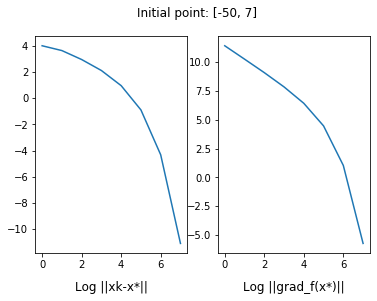

Initial point [20, 7] Start iterating:
Total 8 iterations. Time Cost(s): 0.381 Converged point: [4.99999999996832, 4.00000000000236] 



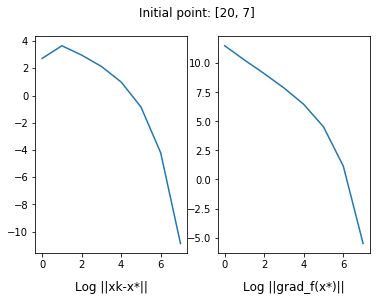

Initial point [20, -18] Start iterating:
Total 16 iterations. Time Cost(s): 0.672 Converged point: [11.4127789869019, -0.896805253274496] 



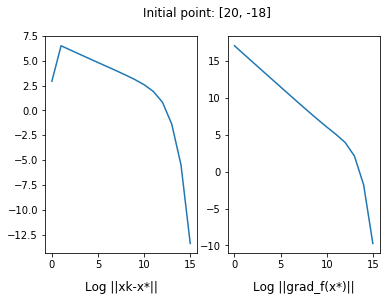

Initial point [-8, -50] Start iterating:
Total 21 iterations. Time Cost(s): 0.735 Converged point: [11.4127789869021, -0.896805253274476] 



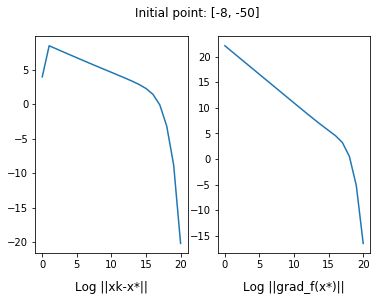

In [173]:
# Test initial points
intial_points = [ [-50, 7], [20, 7], [20, -18], [-8, -50] ]
# Apply Globalized Newton Method
for point in intial_points:
    
    xn, gn_norm, converged_point = newton_glob(f, point, 1e-8, 1e-6, 1e-6, 0.1, 1, 0.5, 0.1)
    
    # calculate for plot
    xk_minus_xstar_norm = []
    for xk in xn:
        k1 = float(xk[0] - converged_point[0])
        k2 = float(xk[1] - converged_point[1])
        norm = np.sqrt(k1 ** 2 + k2 ** 2)
        xk_minus_xstar_norm.append(norm)
    
    plt.figure()
    plt.subplot(121)
    plt.plot(np.log(xk_minus_xstar_norm))
    plt.title('Log ||xk-x*||', y=-0.2)
    plt.subplot(122)
    plt.plot(np.log(gn_norm))
    plt.title('Log ||grad_f(x*)||', y=-0.2)
    
    plt.suptitle('Initial point: {}'.format(point))
    plt.show()

In [100]:
# Apply Gradient Method
for point in intial_points[0:]:
    
    xn, gn_norm, converged_point = newton_glob(f, point, 1e-5, 1e-6, 1e-6, 0.1, 1, 0.5, 0.1, grad_method=True)

Initial point [-50, 7] Start iterating:
Total 6596 iterations. Time Cost(s): 354.818 Coverage points: [11.4127696797573, -0.896805799403163] 

Initial point [20, 7] Start iterating:
Total 8858 iterations. Time Cost(s): 618.710 Coverage points: [5.00000247891144, 3.99999995558952] 

Initial point [20, -18] Start iterating:
Total 8767 iterations. Time Cost(s): 604.106 Coverage points: [5.00000256776246, 3.99999995413150] 

Initial point [-8, -50] Start iterating:
Total 8758 iterations. Time Cost(s): 619.690 Coverage points: [4.99999749903115, 4.00000004479747] 



In [388]:
# The Conjugate Gradient Method
# parameters
# - A, symmetric and positive definite matrix
# - b, vector b
# - x0, initial point
# - tol, tolerance
# - max_iter, maximum iterations
def cg_method(A,b,x0,tol,max_iter):
    
    start_time = time.time()
    
    r0 = np.dot(A,x0) - b
    p0 = -r0
    x1 = x0
    iterations  = 0
    xk = []
    
    while(iterations < max_iter):
        xk.append(x1)
        a0 = np.dot(r0,r0) / np.dot(np.dot(p0.T,A),p0)
        x1 = x0 + np.dot(a0,p0)
        r1 = r0 + np.dot(np.dot(a0,A),p0)
        
        if(np.linalg.norm(r1) <= tol):
            break
        b0 = np.dot(r1,r1) / np.dot(r0,r0)
        p1 = -r1 + np.dot(b0,p0)
        x0, p0, r0 = x1, p1, r1
        iterations += 1
    
    cpu_time = time.time() - start_time
        
    return x1, iterations, cpu_time, xk

In [396]:
# The Gradient Method with exact line search applied to the quadratic problem
# parameters
# - A, symmetric and positive definite matrix
# - b, vector b
# - x0, initial point
# - tol, tolerance
# - max_iter, maximum iterations
def grad_method(A,b,x0,tol,max_iter):
    
    start_time = time.time()
    x = x0
    iterations  = 0
    g = A.dot(x) - b
    ng = np.linalg.norm(g)
    xk = []
    
    while(iterations < max_iter):
        
        xk.append(x)
        if(ng <= tol):
            break
        
        alpha = ng * ng / g.dot(A.dot(g))
        x = x - alpha * g
        g = np.dot(A, x) - b
        ng = np.linalg.norm(g)
        
        iterations += 1
    
    cpu_time = time.time() - start_time
        
    return x, iterations, cpu_time, xk

In [361]:
# generate test case
def generatePara(n):
    A = np.ones((n, n))
    row, col = np.diag_indices(n)
    A[row,col] = np.array([i for i in range(1, n + 1)])
    
    b = np.ones(n)
    x0 = np.zeros(n)
    
    return A, b, x0

In [362]:
# generate parameters for n = {50, 100, 1000, 2500}
A_50, b_50, x0_50 = generatePara(50)
A_100, b_100, x0_100 = generatePara(100)
A_1000, b_1000, x0_1000 = generatePara(1000)
A_2500, b_2500, x0_2500 = generatePara(2500)

In [389]:
x1_50, iter_50, time_50, xk_50 = cg_method(A_50, b_50, x0_50, 1e-6, 1000)
x1_100, iter_100, time_100, xk_100 = cg_method(A_100, b_100, x0_100, 1e-6, 1000)
x1_1000, iter_1000, time_1000, xk_1000 = cg_method(A_1000, b_1000, x0_1000, 1e-6, 1000)
x1_2500, iter_2500, time_2500, xk_2500 = cg_method(A_2500, b_2500, x0_2500, 1e-6, 1000)

In [383]:
# cg method iterations and cpu_time
print('[cg method results]')
print('n = 50 iterations:', iter_50, 'cpu_time:', time_50)
print('n = 100 iterations:', iter_100, 'cpu_time:', time_100)
print('n = 1000 iterations:', iter_1000, 'cpu_time:', time_1000)
print('n = 2500 iterations:', iter_2500, 'cpu_time:', time_2500)

cg method results
n = 50 iterations: 38 cpu_time: 0.0016148090362548828
n = 100 iterations: 57 cpu_time: 0.002157926559448242
n = 1000 iterations: 192 cpu_time: 3.381535053253174
n = 2500 iterations: 306 cpu_time: 55.568150997161865


In [397]:
gx1_50, giter_50, gtime_50, gxk_50 = grad_method(A_50, b_50, x0_50, 1e-6, 1000000)
gx1_100, giter_100, gtime_100, gxk_100 = grad_method(A_100, b_100, x0_100, 1e-6, 1000000)
gx1_1000, giter_1000, gtime_1000, gxk_1000 = grad_method(A_1000, b_1000, x0_1000, 1e-6, 1000000)
#gx1_2500, giter_2500, gtime_2500, gxk_2500 = grad_method(A_2500, b_2500, x0_2500, 1e-6, 1000000)

In [403]:
gx1_2500, giter_2500, gtime_2500, gxk_2500 = grad_method(A_2500, b_2500, x0_2500, 1e-6, 1000000)

In [386]:
# gradient method iterations and cpu_time
print('[gradient method results]')
print('n = 50 iterations:', giter_50, 'cpu_time:', gtime_50)
print('n = 100 iterations:', giter_100, 'cpu_time:', gtime_100)
print('n = 1000 iterations:', giter_1000, 'cpu_time:', gtime_1000)
print('n = 2500 iterations:', giter_2500, 'cpu_time:', gtime_2500)

[gradient method results]
n = 50 iterations: 2681 cpu_time: 0.03241920471191406
n = 100 iterations: 5943 cpu_time: 0.0871429443359375
n = 1000 iterations: 78277 cpu_time: 15.546622037887573
n = 2500 iterations: 214161 cpu_time: 534.8798232078552


In [387]:
# compare cg method results with numpy.linalg.solve(A,b)
print(x1_50)
print(np.linalg.solve(A_50,b_50))

print(x1_100)
print(np.linalg.solve(A_100,b_100))

print(x1_1000)
print(np.linalg.solve(A_1000,b_1000))

print(x1_2500)
print(np.linalg.solve(A_2500,b_2500))

[ 1.00000000e+00  1.23443633e-12 -8.44750250e-12  5.05892509e-11
 -2.40287071e-10  9.12174227e-10 -2.78870638e-09  6.88714630e-09
 -1.36666292e-08  2.13839378e-08 -2.51771510e-08  1.95458158e-08
 -4.43849242e-09 -1.08844175e-08  1.39244065e-08 -2.54330040e-09
 -9.88031718e-09  8.64769767e-09  3.48210545e-09 -9.40267308e-09
  1.43996538e-09  7.74241032e-09 -4.47251227e-09 -5.27464165e-09
  6.04238366e-09  2.64121303e-09 -6.54331058e-09 -3.70726625e-11
  6.13596956e-09 -2.44977696e-09 -4.74424220e-09  4.57932077e-09
  2.15402436e-09 -5.66716564e-09  1.61944214e-09  4.33140443e-09
 -5.25796568e-09  8.22215456e-10  4.32557846e-09 -6.48722294e-09
  5.55132613e-09 -3.39948651e-09  1.58916055e-09 -5.79548913e-10
  1.65122529e-10 -3.62556367e-11  5.95151207e-12 -6.89137931e-13
  5.11092378e-14 -1.17500128e-15]
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0.]
[ 1.00000000e+00  7.90024445e-13

[1. 0. 0. ... 0. 0. 0.]


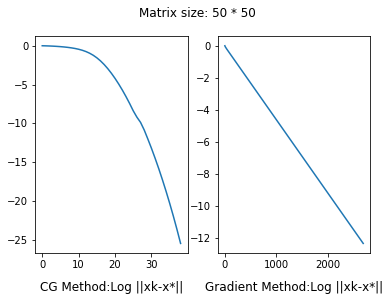

In [400]:
# Compare with two methods in matrix size : 50 * 50
xk_minus_xstar_norm = []
gxk_minus_xstar_norm = []
x_star_50 = np.dot(np.linalg.inv(A_50), b_50)
for xk in xk_50:
    k1 = float(xk[0] - x_star_50[0])
    k2 = float(xk[1] - x_star_50[1])
    norm = np.sqrt(k1 ** 2 + k2 ** 2)
    xk_minus_xstar_norm.append(norm)

for xk in gxk_50:
    k1 = float(xk[0] - x_star_50[0])
    k2 = float(xk[1] - x_star_50[1])
    norm = np.sqrt(k1 ** 2 + k2 ** 2)
    gxk_minus_xstar_norm.append(norm)
    
plt.figure()
plt.subplot(121)
plt.plot(np.log(xk_minus_xstar_norm))
plt.title('CG Method:Log ||xk-x*||', y=-0.2)
plt.subplot(122)
plt.plot(np.log(gxk_minus_xstar_norm))
plt.title('Gradient Method:Log ||xk-x*||', y=-0.2)

plt.suptitle('Matrix size: 50 * 50')
plt.show()

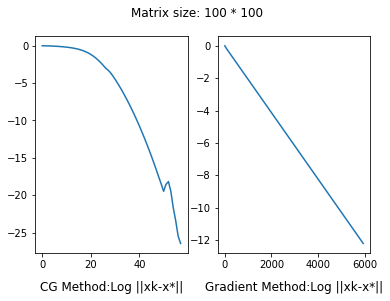

In [401]:
# Compare with two methods in matrix size : 100 * 100
xk_minus_xstar_norm = []
gxk_minus_xstar_norm = []
x_star_100 = np.dot(np.linalg.inv(A_100), b_100)
for xk in xk_100:
    k1 = float(xk[0] - x_star_50[0])
    k2 = float(xk[1] - x_star_50[1])
    norm = np.sqrt(k1 ** 2 + k2 ** 2)
    xk_minus_xstar_norm.append(norm)

for xk in gxk_100:
    k1 = float(xk[0] - x_star_50[0])
    k2 = float(xk[1] - x_star_50[1])
    norm = np.sqrt(k1 ** 2 + k2 ** 2)
    gxk_minus_xstar_norm.append(norm)
    
plt.figure()
plt.subplot(121)
plt.plot(np.log(xk_minus_xstar_norm))
plt.title('CG Method:Log ||xk-x*||', y=-0.2)
plt.subplot(122)
plt.plot(np.log(gxk_minus_xstar_norm))
plt.title('Gradient Method:Log ||xk-x*||', y=-0.2)

plt.suptitle('Matrix size: 100 * 100')
plt.show()

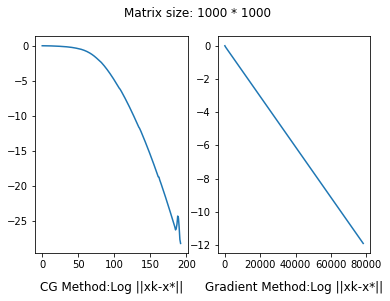

In [402]:
# Compare with two methods in matrix size : 1000 * 1000
xk_minus_xstar_norm = []
gxk_minus_xstar_norm = []
x_star_1000 = np.dot(np.linalg.inv(A_1000), b_1000)
for xk in xk_1000:
    k1 = float(xk[0] - x_star_50[0])
    k2 = float(xk[1] - x_star_50[1])
    norm = np.sqrt(k1 ** 2 + k2 ** 2)
    xk_minus_xstar_norm.append(norm)

for xk in gxk_1000:
    k1 = float(xk[0] - x_star_50[0])
    k2 = float(xk[1] - x_star_50[1])
    norm = np.sqrt(k1 ** 2 + k2 ** 2)
    gxk_minus_xstar_norm.append(norm)
    
plt.figure()
plt.subplot(121)
plt.plot(np.log(xk_minus_xstar_norm))
plt.title('CG Method:Log ||xk-x*||', y=-0.2)
plt.subplot(122)
plt.plot(np.log(gxk_minus_xstar_norm))
plt.title('Gradient Method:Log ||xk-x*||', y=-0.2)

plt.suptitle('Matrix size: 1000 * 1000')
plt.show()

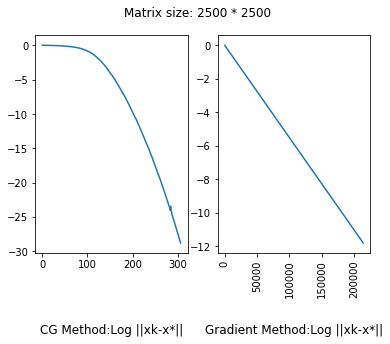

In [408]:
# Compare with two methods in matrix size : 2500 * 2500
xk_minus_xstar_norm = []
gxk_minus_xstar_norm = []
x_star_2500 = np.dot(np.linalg.inv(A_2500), b_2500)
for xk in xk_2500:
    k1 = float(xk[0] - x_star_50[0])
    k2 = float(xk[1] - x_star_50[1])
    norm = np.sqrt(k1 ** 2 + k2 ** 2)
    xk_minus_xstar_norm.append(norm)

for xk in gxk_2500:
    k1 = float(xk[0] - x_star_50[0])
    k2 = float(xk[1] - x_star_50[1])
    norm = np.sqrt(k1 ** 2 + k2 ** 2)
    gxk_minus_xstar_norm.append(norm)
    
plt.figure()
plt.subplot(121)
plt.plot(np.log(xk_minus_xstar_norm))
plt.title('CG Method:Log ||xk-x*||', y=-0.4)
plt.subplot(122)
plt.plot(np.log(gxk_minus_xstar_norm))
plt.title('Gradient Method:Log ||xk-x*||', y=-0.4)
plt.xticks(rotation=90)

plt.suptitle('Matrix size: 2500 * 2500')
plt.show()